In [114]:
import numpy as np     
import pandas as pd    
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
# load the dataset containing normalized text as well as the additional features obtained from notebook 1

df_train = pd.read_csv('Data\\disaster_tweets_kaggle\\train_clean_add_feat.csv', index_col = False)

df_train.head()

,text,target,text_norm,stemmed_keyword,disaster_asc_coeff,length_norm,neg,neu,pos
0,Our Deeds are the Reason of this #earthquake M...,1,deed reason earthquak may allah forgiv us,earthquak,0.785714,41,0.000,1.000,0.0
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la rong sask canada,fire,0.386364,36,0.286,0.714,0.0
2,All residents asked to 'shelter in place' are ...,1,resid ask shelter place notifi offic evacu she...,evacu,0.767241,69,0.000,1.000,0.0
3,"13,000 people receive #wildfires evacuation or...",1,13000 peopl receiv wildfir evacu order california,evacu,0.767241,49,0.000,1.000,0.0
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo rubi alaska smoke wildfir pour ...,fire,0.386364,52,0.000,1.000,0.0


In [116]:
# In this part we will compare results using the original text with minimum processing vs the normalized text 
df_orig = df_train[['text', 'target']]
df_norm = df_train[['text_norm', 'target']]

## 1) Training with Normalized Text Data
For this text data, stop words, symbols, urls and punctuations have been removed. In addition, the words have also been stemmed. This means that the vocabulariy will be smaller; however, any contextual information provided by stop words will be lost.

#### Prepare text data for embedding

In [117]:
# use tokenizer and padding to prepare data for embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [118]:
tokenizer = Tokenizer()

In [119]:
# fit text to data
tokenizer.fit_on_texts(df_norm['text_norm'])

In [120]:
# tokenize text data
df_tokens = tokenizer.texts_to_sequences(df_norm['text_norm'])
df_tokens[0]

[3855, 471, 218, 93, 1405, 3035, 18]

In [138]:
# get max length to pad sequences and abd vocab size
VOCAB_SIZE = len(tokenizer.word_index) + 1
MAX_LENGTH = max([len(text.split()) for text in df_norm['text_norm']])
EMBEDDING_DIM = 200
print(f'Vocab size: {VOCAB_SIZE}')
print(f'Max sequence length: {MAX_LENGTH}')
print(f'Embedding dim: {EMBEDDING_DIM}')

Vocab size: 19542
Max sequence length: 25
Embedding dim: 200


In [139]:
# add padding
df_pad = pad_sequences(df_tokens, maxlen = MAX_LENGTH, padding = 'post')
df_pad[0]

array([3855,  471,  218,   93, 1405, 3035,   18,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0])

In [140]:
print(type(df_pad))
print(df_pad.shape)

<class 'numpy.ndarray'>
(7593, 25)


### Train Test Split

In [141]:
from sklearn.model_selection import train_test_split

In [142]:
X = df_pad
y = df_norm['target']

In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [144]:
X_train[0]

array([  299,    27,   184,     6,   187,    38,   976,    73,   394,
         404,   217,  1133,   749, 10815,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0])

### Simple RNN model
Since the goal is to train a binary classification model, the RNN architecture will be many-to-one.

In [145]:
# basic architecture from tensorflow classiication with RNN documentation
import tensorflow as tf

In [146]:
model = tf.keras.Sequential()

The embedding layer converts the numeric representation of a word which would be a vector the length of the vocabularity if it were a dummy variable(with all entried 0's ecxept 1) and converts it to a vector of fixed length with all entries as floating point values. Therefore, instead of having a large sparse matrix for a sentence, we will have a smaller dense matrix as input. <br>
input_dim : Size of the vocabulary <br>
output_dim : Length of the embedded vector for each word <br>
input_length : Maximum length of a sequence

In [147]:
model.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.SimpleRNN(EMBEDDING_DIM, dropout = 0.3))
model.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [148]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 25, 200)           3908400   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 200)               80200     
                                                                 
 dense_28 (Dense)            (None, 200)               40200     
                                                                 
 dropout_14 (Dropout)        (None, 200)               0         
                                                                 
 dense_29 (Dense)            (None, 64)                12864     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)               

In [149]:
# compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [150]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
30/30 [==============================] - 5s 93ms/step - loss: 0.6912 - accuracy: 0.5240 - val_loss: 0.6885 - val_accuracy: 0.5715
Epoch 2/7
30/30 [==============================] - 2s 75ms/step - loss: 0.6856 - accuracy: 0.5801 - val_loss: 0.6850 - val_accuracy: 0.5763
Epoch 3/7
30/30 [==============================] - 2s 76ms/step - loss: 0.6778 - accuracy: 0.5945 - val_loss: 0.6797 - val_accuracy: 0.5833
Epoch 4/7
30/30 [==============================] - 2s 75ms/step - loss: 0.6612 - accuracy: 0.6210 - val_loss: 0.6640 - val_accuracy: 0.6124
Epoch 5/7
30/30 [==============================] - 2s 76ms/step - loss: 0.6068 - accuracy: 0.7080 - val_loss: 0.5981 - val_accuracy: 0.7036
Epoch 6/7
30/30 [==============================] - 2s 76ms/step - loss: 0.4749 - accuracy: 0.8029 - val_loss: 0.5559 - val_accuracy: 0.7508
Epoch 7/7
30/30 [==============================] - 2s 76ms/step - loss: 0.3356 - accuracy: 0.8768 - val_loss: 0.5722 - val_accuracy: 0.7555


In [151]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.709000962972641)

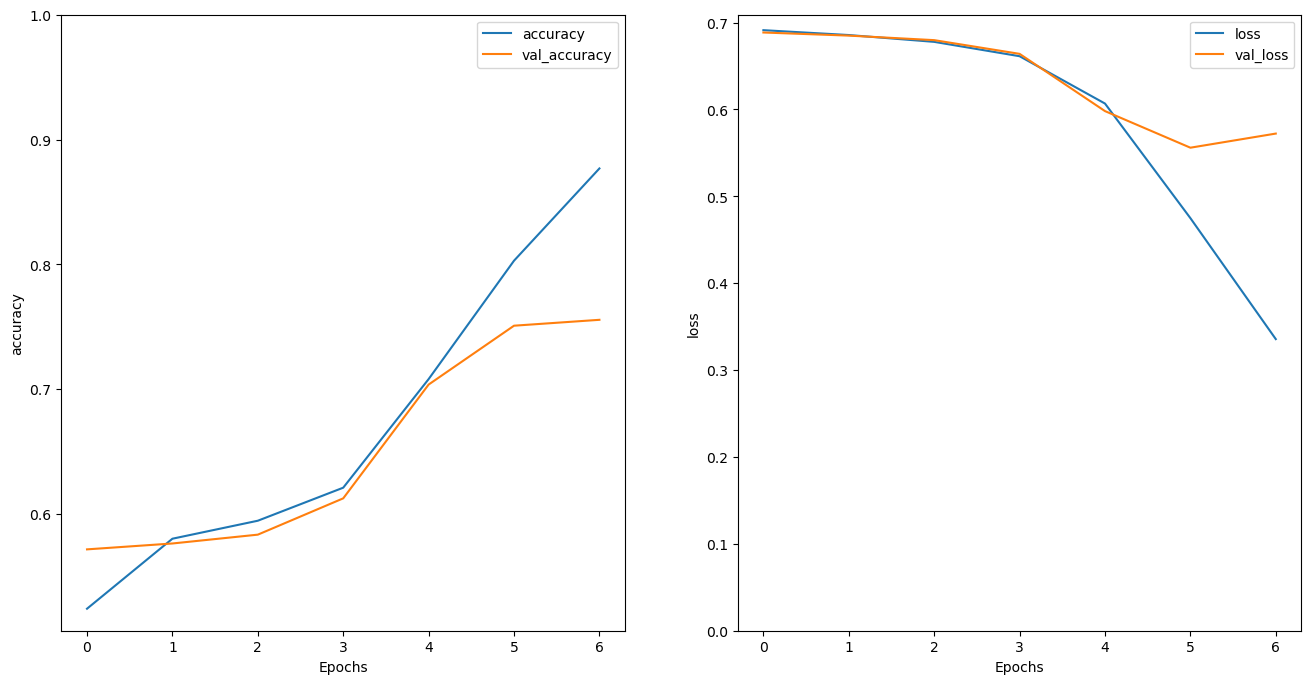

In [152]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [153]:
test_loss, test_acc = model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 7ms/step - loss: 0.5548 - accuracy: 0.7566


In [154]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.5548453330993652
Test Accuracy: 0.7565842270851135


### LSTM

In [155]:
model_lstm = tf.keras.Sequential()

In [156]:
model_lstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_lstm.add(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3))
model_lstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_lstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_lstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [158]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 25, 200)           3908400   
                                                                 
 lstm (LSTM)                 (None, 200)               320800    
                                                                 
 dense_32 (Dense)            (None, 200)               40200     
                                                                 
 dropout_16 (Dropout)        (None, 200)               0         
                                                                 
 dense_33 (Dense)            (None, 64)                12864     
                                                                 
 dropout_17 (Dropout)        (None, 64)                0         
                                                                 
 dense_34 (Dense)            (None, 32)               

In [159]:
# compile model
model_lstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [160]:
history = model_lstm.fit(X_train, y_train, batch_size = 128, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
30/30 [==============================] - 11s 192ms/step - loss: 0.6927 - accuracy: 0.5394 - val_loss: 0.6916 - val_accuracy: 0.5645
Epoch 2/7
30/30 [==============================] - 4s 139ms/step - loss: 0.6906 - accuracy: 0.5675 - val_loss: 0.6892 - val_accuracy: 0.5645
Epoch 3/7
30/30 [==============================] - 4s 139ms/step - loss: 0.6868 - accuracy: 0.5675 - val_loss: 0.6844 - val_accuracy: 0.5645
Epoch 4/7
30/30 [==============================] - 4s 141ms/step - loss: 0.6735 - accuracy: 0.5675 - val_loss: 0.6593 - val_accuracy: 0.5645
Epoch 5/7
30/30 [==============================] - 5s 170ms/step - loss: 0.5963 - accuracy: 0.6891 - val_loss: 0.5941 - val_accuracy: 0.7893
Epoch 6/7
30/30 [==============================] - 5s 171ms/step - loss: 0.4706 - accuracy: 0.8626 - val_loss: 0.5571 - val_accuracy: 0.7649
Epoch 7/7
30/30 [==============================] - 5s 170ms/step - loss: 0.3360 - accuracy: 0.8868 - val_loss: 0.5527 - val_accuracy: 0.7681


In [165]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7104931235313415)

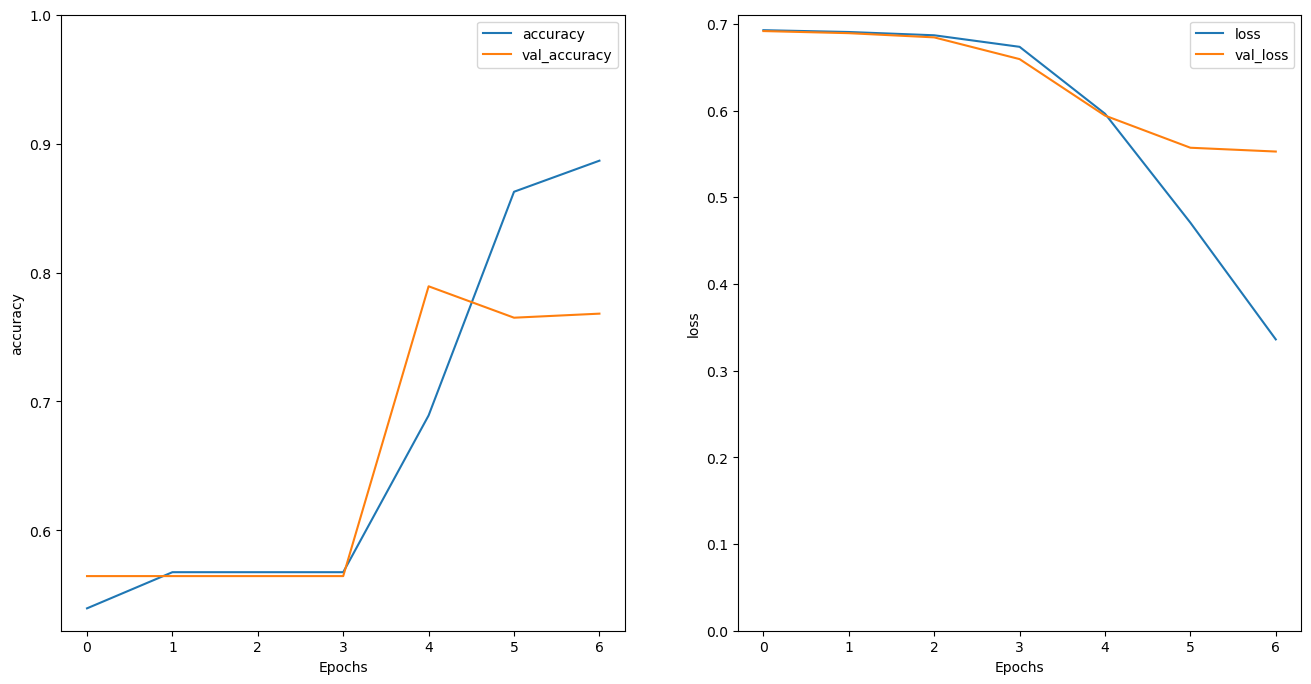

In [166]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [169]:
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)

79/79 [==============================] - 1s 16ms/step - loss: 0.5663 - accuracy: 0.7582


In [170]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.566309928894043
Test Accuracy: 0.7581803798675537


### Bidirectional LSTM

In [171]:
model_blstm = tf.keras.Sequential()

In [173]:
model_blstm.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model_blstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIM, dropout = 0.3)))
model_blstm.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(64, activation='relu'))
model_blstm.add(tf.keras.layers.Dropout(rate = 0.25))
model_blstm.add(tf.keras.layers.Dense(32, activation='relu'))
model_blstm.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [174]:
model_blstm.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 25, 200)           3908400   
                                                                 
 bidirectional (Bidirectiona  (None, 400)              641600    
 l)                                                              
                                                                 
 dense_36 (Dense)            (None, 200)               80200     
                                                                 
 dropout_18 (Dropout)        (None, 200)               0         
                                                                 
 dense_37 (Dense)            (None, 64)                12864     
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                      

In [175]:
# compile model
model_blstm.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [176]:
history = model_blstm.fit(X_train, y_train, batch_size = 128, epochs = 7,
                    validation_split = 0.25)

Epoch 1/7
30/30 [==============================] - 18s 325ms/step - loss: 0.6921 - accuracy: 0.5586 - val_loss: 0.6911 - val_accuracy: 0.5645
Epoch 2/7
30/30 [==============================] - 8s 283ms/step - loss: 0.6893 - accuracy: 0.5675 - val_loss: 0.6875 - val_accuracy: 0.5645
Epoch 3/7
30/30 [==============================] - 12s 408ms/step - loss: 0.6827 - accuracy: 0.5675 - val_loss: 0.6775 - val_accuracy: 0.5645
Epoch 4/7
30/30 [==============================] - 11s 363ms/step - loss: 0.6507 - accuracy: 0.5751 - val_loss: 0.6224 - val_accuracy: 0.6769
Epoch 5/7
30/30 [==============================] - 10s 335ms/step - loss: 0.5281 - accuracy: 0.8063 - val_loss: 0.5471 - val_accuracy: 0.7885
Epoch 6/7
30/30 [==============================] - 9s 286ms/step - loss: 0.3370 - accuracy: 0.9017 - val_loss: 0.6014 - val_accuracy: 0.7697
Epoch 7/7
30/30 [==============================] - 9s 286ms/step - loss: 0.2176 - accuracy: 0.9287 - val_loss: 0.6944 - val_accuracy: 0.7673


In [177]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.7182628780603408)

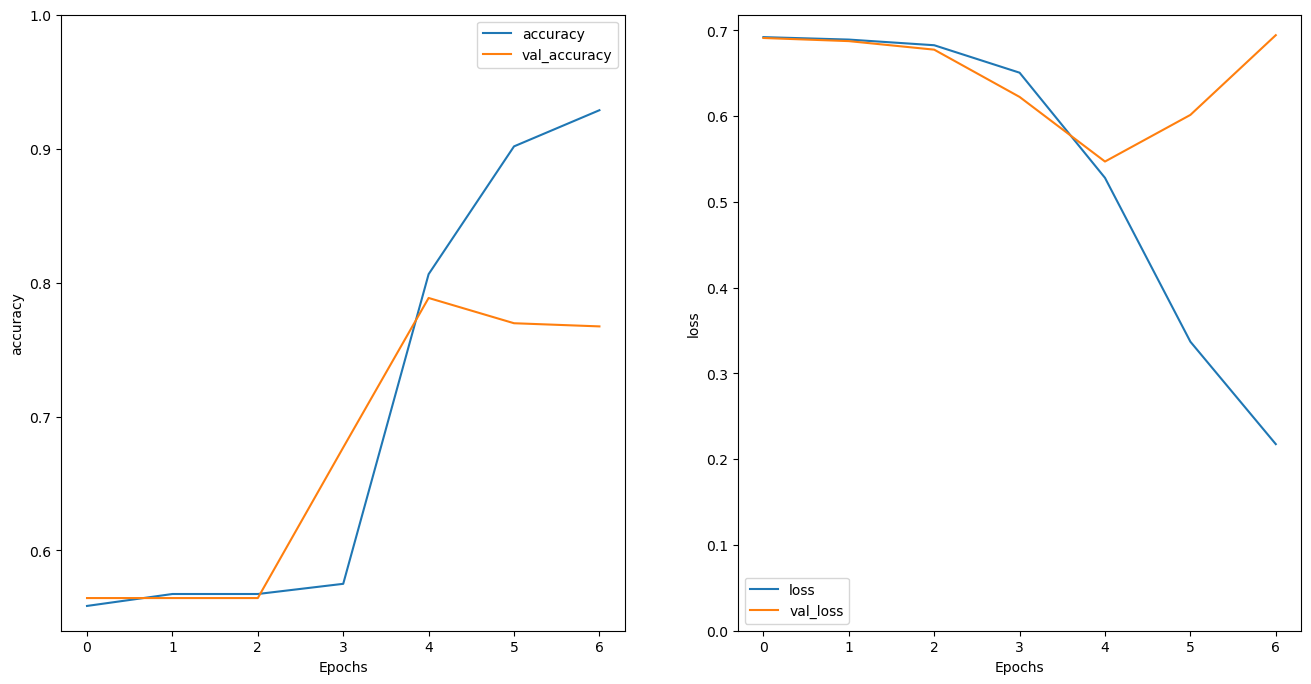

In [178]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [179]:
test_loss, test_acc = model_blstm.evaluate(X_test, y_test)

79/79 [==============================] - 2s 27ms/step - loss: 0.6949 - accuracy: 0.7594


In [180]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.6948634386062622
Test Accuracy: 0.7593774795532227


### GRU

In [129]:
model = tf.keras.Sequential()

The embedding layer converts the numeric representation of a word which would be a vector the length of the vocabularity if it were a dummy variable(with all entried 0's ecxept 1) and converts it to a vector of fixed length with all entries as floating point values. Therefore, instead of having a large sparse matrix for a sentence, we will have a smaller dense matrix as input. <br>
input_dim : Size of the vocabulary <br>
output_dim : Length of the embedded vector for each word <br>
input_length : Maximum length of a sequence

In [130]:
model.add(tf.keras.layers.Embedding(input_dim = VOCAB_SIZE,
        output_dim = EMBEDDING_DIM, input_length = MAX_LENGTH, mask_zero=True))
model.add(tf.keras.layers.SimpleRNN(EMBEDDING_DIM, dropout = 0.3))
model.add(tf.keras.layers.Dense(EMBEDDING_DIM, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(rate = 0.25))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

In [131]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 25, 200)           3908400   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 200)               80200     
                                                                 
 dense_24 (Dense)            (None, 200)               40200     
                                                                 
 dropout_12 (Dropout)        (None, 200)               0         
                                                                 
 dense_25 (Dense)            (None, 64)                12864     
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_26 (Dense)            (None, 32)               

In [132]:
# compile model
model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(1e-4),
              metrics = ['accuracy'])

### Train Model

In [133]:
history = model.fit(X_train, y_train, batch_size = 128, epochs = 7,
                    validation_split = 0.25)

Epoch 1/5
30/30 [==============================] - 4s 88ms/step - loss: 0.6924 - accuracy: 0.5229 - val_loss: 0.6895 - val_accuracy: 0.5668
Epoch 2/5
30/30 [==============================] - 2s 76ms/step - loss: 0.6863 - accuracy: 0.5688 - val_loss: 0.6851 - val_accuracy: 0.5920
Epoch 3/5
30/30 [==============================] - 2s 75ms/step - loss: 0.6789 - accuracy: 0.5874 - val_loss: 0.6806 - val_accuracy: 0.6046
Epoch 4/5
30/30 [==============================] - 2s 76ms/step - loss: 0.6693 - accuracy: 0.6100 - val_loss: 0.6711 - val_accuracy: 0.6368
Epoch 5/5
30/30 [==============================] - 2s 76ms/step - loss: 0.6301 - accuracy: 0.7007 - val_loss: 0.6223 - val_accuracy: 0.6918


In [134]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

(0.0, 0.695869779586792)

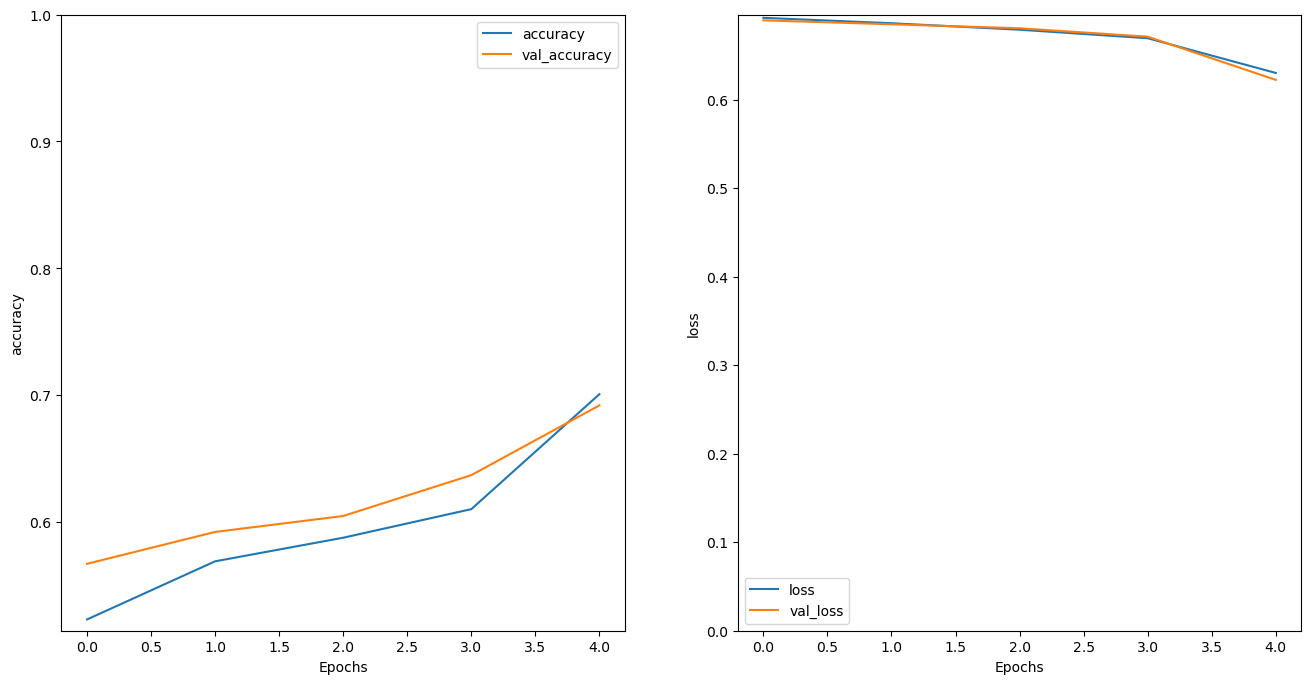

In [135]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [136]:
test_loss, test_acc = model.evaluate(X_test, y_test)

79/79 [==============================] - 1s 7ms/step - loss: 0.6273 - accuracy: 0.6879


In [137]:
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

Test Loss: 0.6272757649421692
Test Accuracy: 0.6879489421844482
